In [27]:
#  https://github.com/pytorch/tutorials/blob/main/beginner_source/transfer_learning_tutorial.py
# Dataset: https://download.pytorch.org/tutorial/hymenoptera_data.zip

import os
import torch
import numpy as np
import copy
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

# 1. Loading Data

In [40]:
def load_dataloaders(data_dir, data_transforms, training_phase_names = ['train', 'val']):
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in training_phase_names}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in training_phase_names}

    # 
    class_names = image_datasets[training_phase_names[0]].classes
    datasets_size = {x: len(image_datasets[x]) for x in training_phase_names}

    return dataloaders, class_names, datasets_size
    

data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize([0.482, 0.456, 0.408], [0.228, 0.224, 0.234])
            ]),

        'val': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize([0.482, 0.456, 0.408], [0.228, 0.224, 0.234])
            ])
        }
data_dir = '~/Downloads/hymenoptera_data'
training_phase_names = ['train', 'val']
dataloaders, class_names, datasets_size = load_dataloaders(data_dir, data_transforms, training_phase_names)

# 2. Visualize Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


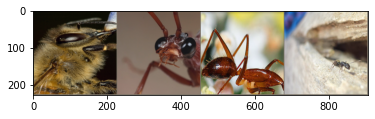

In [20]:
def visualize_images(images):
    images = images.numpy().transpose((1,2,0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = mean + images * std
    
    plt.imshow(images)

# get training data batch
inputs, classes = next(iter(dataloaders['train']))
images = make_grid(inputs)
visualize_images(images)

In [22]:
# print(classes)
# print(images.shape)
# print(inputs.shape)

# 3. FineTuning the Model

In [51]:
import torchvision.models as models

def list_torchvision_models():
    """
    List all available models in torchvision.models module.
    """
    model_names = sorted(name for name in models.__dict__
                         if name.islower() and not name.startswith("__")
                         and callable(models.__dict__[name]))
    print("Available models:\n", model_names)
    
list_torchvision_models()


Available models:
 ['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_weight', 'googlenet', 'inception_v3', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_

In [55]:
def train_model(model, criterion, optimizer, scheduler = None, num_epochs=5):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy, best_epoch = 0.0, 0
    
    phases_loss = {x: [] for x in training_phase_names}
    phases_accuracy = {x: [] for x in training_phase_names}
    
    
    for epoch in range(num_epochs):
        for phase in training_phase_names:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for images, labels in dataloaders[phase]:
                images = images.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # print statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
            # compute accuracy
            epoch_loss = running_loss / datasets_size[phase]
            epoch_accuracy = float(running_corrects / datasets_size[phase])
            
            phases_loss[phase].append(epoch_loss)
            phases_accuracy[phase].append(epoch_accuracy)
            
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_epoch = epoch
                best_model_weights = copy.deepcopy(model.state_dict())
            
        # 
        if phase == 'train':
            scheduler.step()
    
    return phases_loss, phases_accuracy, best_model_weights, best_accuracy


# define the model, loss and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
# model = models.densenet121(pretrained=True)
num_features = model.fc.in_features
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9) 
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)


# train model
phases_loss, phases_accuracy, best_model_weights, best_accuracy = train_model(model,
    criterion, optimizer, scheduler, num_epochs=2)


/home/yukikongju/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
print(phases_loss)
print(phases_accuracy)
print(datasets_size)

{'train': [4.677015955330895, 0.6263744365729269], 'val': [1.7241711036052578, 0.6506569406955071]}
{'train': [0.3155737817287445, 0.7991803288459778], 'val': [0.5947712659835815, 0.8366013169288635]}
{'train': 244, 'val': 153}
